In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import os
import seaborn as sns
from IPython.display import display
import numpy as np
import re
import json


pd.options.display.max_columns = None
%matplotlib inline

# 한글 폰트
plt.rcParams['font.family'] = 'NanumGothic'
# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 나눔 고딕의 경로
font_prop = fm.FontProperties(fname=font_path).get_name()

# 한글 폰트 설정
matplotlib.rcParams['font.family'] = font_prop

# 전역 팔레트 설정 (예: 'Set2' 팔레트 사용)
sns.set_palette('Set2')


In [2]:
# 불러오기
preseason = pd.read_csv('../datas/Pre_Season_Batter.csv')
for i, j in preseason.isnull().sum().items():
    if not j == 0:
        print(i, j)


starting_salary 214


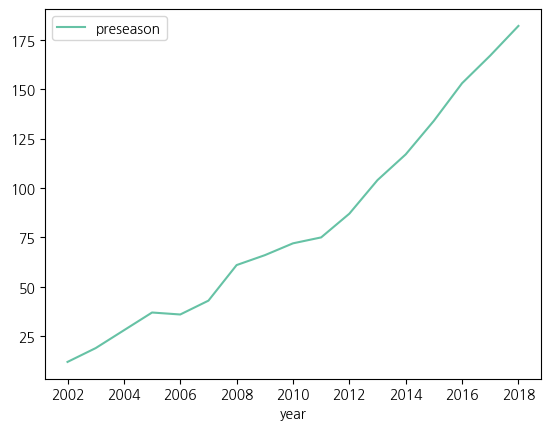

In [3]:
# 연도별 선수 수 확인

'''
그렇다면 각 연도별 등록된 선수의 수는 어떻게 될지 한 번 살펴보았다.
'''

batter_count_preseason = preseason.groupby('year')['batter_id'].count().rename('preseason').reset_index()
batter_count_preseason
batter_count_preseason.plot(kind='line', x='year', y='preseason')

'''
최근으로 올 수록 등록된 선수의 수가 늘어나는 것을 볼 수 있다.
''';


In [4]:
'''
이제 프리시즌과 정규시즌의 상관관계를 보려고 한다.
프리시즌의 성적이 정규시즌에 영향을 미치는가?

프리시즌에 성적이 좋았던 선수들은 과연 정규시즌에서도 성적이 좋은지 확인하려고 한다.

먼저 정규시즌을 불러오고 결측값을 확인한 후 채우는 작업을 한다.
'''

regular_season = pd.read_csv('../datas/Regular_Season_Batter.csv')
regular_season.head()


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,pos,hand,country
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,내야수,우타,외국인
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,내야수,좌타,한국인
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,내야수,좌타,한국인
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,내야수,좌타,한국인
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,내야수,좌타,한국인


In [5]:
'''
타율, SLG, OBP에서 각각 결측값이 발견되었다.
'''

regular_season.isna().sum()


batter_id             0
batter_name           0
year                  0
team                  0
avg                   0
G                     0
AB                    0
R                     0
H                     0
2B                    0
3B                    0
HR                    0
TB                    0
RBI                   0
SB                    0
CS                    0
BB                    0
HBP                   0
SO                    0
GDP                   0
SLG                   0
OBP                   0
E                     0
height/weight         0
year_born             0
position              0
career                0
starting_salary    1067
OPS                   0
pos                   0
hand                  0
country               0
dtype: int64

In [6]:
# 정규시즌 결측값 채우기

'''
먼저 SLG, OBP는 앞서 사용한 방식을 이용하여 채워주었다.
'''

def SLG_calc(row):
    # SLG가 NaN이 아닐 경우 그대로 반환
    if pd.notna(row['SLG']):
        return row['SLG']
    # 타수가 없는 경우
    if pd.notna(row['AB']) or row['AB'] == 0:
        return 0
    H = row['H'] - row[['2B', '3B', 'HR']].sum()
    SLG = (H + row['2B'] * 2 + row['3B'] * 3 + row['HR'] * 4) / row['AB']

    return SLG

def OBP_calc(row):
    # OBP가 NaN이 아닐 경우 그대로 반환
    if pd.notna(row['OBP']):
        return row['OBP']
    
    denominator = row[['H', 'BB', 'HBP']].sum()
    numerator = row[['AB', 'BB', 'HBP']].sum()
    
    # 분모 또는 분자가 0 인경우
    if denominator == 0 or numerator == 0:
        return 0
    
    OBP = denominator / numerator
    return OBP

# SLG 결측값 채우기
regular_season['SLG'] = regular_season.apply(SLG_calc, axis=1)
# OBP 결측값 채우기
regular_season['OBP'] = regular_season.apply(OBP_calc, axis=1)

# 결측값 확인
print(regular_season.isna().sum())


batter_id             0
batter_name           0
year                  0
team                  0
avg                   0
G                     0
AB                    0
R                     0
H                     0
2B                    0
3B                    0
HR                    0
TB                    0
RBI                   0
SB                    0
CS                    0
BB                    0
HBP                   0
SO                    0
GDP                   0
SLG                   0
OBP                   0
E                     0
height/weight         0
year_born             0
position              0
career                0
starting_salary    1067
OPS                   0
pos                   0
hand                  0
country               0
dtype: int64


In [7]:
'''
이제 SLG와 OBP를 채워주었으니 둘을 이용해 OPS를 채워주었다.
'''

def OPS_clac(row):
    # OBP가 NaN이 아닐 경우 그대로 반환
    if pd.notna(row['OPS']):
        return row['OPS']
    
    OPS = row[['SLG', 'OBP']].sum()
    return OPS

# OPS 결측값 채우기
regular_season['OPS'] = regular_season.apply(OPS_clac, axis=1)

# 결측값 확인
regular_season.isna().sum()


batter_id             0
batter_name           0
year                  0
team                  0
avg                   0
G                     0
AB                    0
R                     0
H                     0
2B                    0
3B                    0
HR                    0
TB                    0
RBI                   0
SB                    0
CS                    0
BB                    0
HBP                   0
SO                    0
GDP                   0
SLG                   0
OBP                   0
E                     0
height/weight         0
year_born             0
position              0
career                0
starting_salary    1067
OPS                   0
pos                   0
hand                  0
country               0
dtype: int64

In [8]:
'''
이제 타율을 채워주도록 하자

타율은 안타 / 타수로
AVG = H / AB 로 계산한다.

먼저 제대로 맞는지 확인해 보자
'''

print(regular_season.loc[0, 'H'] / regular_season.loc[0, 'AB'])
print(regular_season.loc[0, 'avg'])

'''
셋째 자리엣 반올림 하면 될 것 같다.
공식을 이용해서 적용했다.
'''

def AVG_calc(row):
    # avg가 이미 채워진 경우
    if pd.notna(row['avg']):
        return row['avg']
    # 타수 또는 안타가 0인 경우
    if row['AB'] == 0 or row['H'] == 0:
        return 0
    
    avg = regular_season.loc[0, 'H'] / regular_season.loc[0, 'AB']
    avg = round(avg, 3)
    return avg

regular_season['avg'] = regular_season.apply(AVG_calc, axis=1)

# 결측값 확인
print(regular_season.isna().sum())

# 데이터 저장
regular_season.to_csv('../datas/Regular_Season_Batter.csv', encoding='utf-8-sig', index=False)

# 다시 불러오기
regular_season = pd.read_csv('../datas/Regular_Season_Batter.csv')


0.33879781420765026
0.339
batter_id             0
batter_name           0
year                  0
team                  0
avg                   0
G                     0
AB                    0
R                     0
H                     0
2B                    0
3B                    0
HR                    0
TB                    0
RBI                   0
SB                    0
CS                    0
BB                    0
HBP                   0
SO                    0
GDP                   0
SLG                   0
OBP                   0
E                     0
height/weight         0
year_born             0
position              0
career                0
starting_salary    1067
OPS                   0
pos                   0
hand                  0
country               0
dtype: int64


In [9]:
'''
먼저 정규시즌도 프리시즌과 똑같이 기초통계량을 확인해 보았다.
'''

display(regular_season.describe())

'''
정규 시즌은 프리시즌과 다르게 선수의 수가 매우 많다.

기록된 연도 또한 93년 부터 18년까지 존재한다.

그렇다면 프리시즌과 비교할 때 문제가 생길 수 있으므로 정규시즌과 프리시즌 두 곳에 모두 있는 선수과 연도만 사용해야할 것 같다.
''';


,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000
mean,178.079462,2011.614507,0.235042,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,84.279136,27.788509,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.340183,0.303684,3.676447,0.643868
std,97.557947,4.992833,0.100894,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,82.854200,29.602966,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.166238,0.115253,4.585248,0.268184
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.200000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.263158,0.269000,0.000000,0.541000
50%,183.000000,2013.000000,0.253000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.358000,0.328000,2.000000,0.686000
75%,265.000000,2016.000000,0.290000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.434946,0.367000,5.000000,0.797000
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


In [10]:
'''
각 시즌에서 타자이름, 연도를 이용하여 새로운 인덱스를 만들고, 그 인덱스들을 교집합하여 나온 데이터를 이용하려고 한다.
'''

regular_season['new_index'] = regular_season['batter_name'] + regular_season['year'].apply(str)
preseason['new_index'] = preseason['batter_name'] + preseason['year'].apply(str)

intersection_batter = list(set(regular_season['new_index']).intersection(set(preseason['new_index'])))
print('교집합 된 선수의 수: ',len(intersection_batter))
print(sorted(intersection_batter))

'''
처음에 이상했다.
분명 앞에서 프리시즌을 확인 했을 때는 344명이였는데 왜 1358명이라는 교집합 수가 나올까
그래서 다시 확인 했는데 count 수를 보지 않고 max 수를 보았다....
''';


교집합 된 선수의 수:  1358
['가르시아2018', '강경학2011', '강경학2014', '강경학2015', '강경학2016', '강경학2017', '강구성2013', '강구성2016', '강구성2017', '강민국2014', '강민국2015', '강민국2016', '강민호2005', '강민호2006', '강민호2007', '강민호2008', '강민호2009', '강민호2010', '강민호2011', '강민호2012', '강민호2013', '강민호2014', '강민호2015', '강민호2016', '강민호2017', '강민호2018', '강백호2018', '강상원2017', '강상원2018', '강승호2016', '강승호2017', '강승호2018', '강진성2017', '강진성2018', '강한울2014', '강한울2015', '강한울2017', '강한울2018', '고종욱2011', '고종욱2015', '고종욱2016', '고종욱2017', '고종욱2018', '구자욱2015', '구자욱2016', '구자욱2017', '구자욱2018', '국해성2012', '국해성2015', '국해성2016', '국해성2017', '국해성2018', '권정웅2016', '권정웅2017', '권정웅2018', '권희동2013', '권희동2014', '권희동2017', '권희동2018', '김강민2003', '김강민2004', '김강민2005', '김강민2006', '김강민2007', '김강민2008', '김강민2009', '김강민2010', '김강민2011', '김강민2012', '김강민2013', '김강민2014', '김강민2015', '김강민2016', '김강민2017', '김강민2018', '김동엽2016', '김동엽2017', '김동엽2018', '김동욱2013', '김동욱2015', '김동욱2016', '김동욱2017', '김동욱2018', '김동한2013', '김동한2016', '김동한2017', '김동한2018', '김문호2007', '김문호2008', 

In [11]:
# 교집합 된 데이터만 불러오기
regular_season_intersection = regular_season.loc[regular_season['new_index'].apply(lambda x : x in intersection_batter)]
regular_season_intersection.describe()


,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000,1358.000000
mean,173.113402,2013.027246,0.251213,85.333579,247.955081,37.701767,70.106775,12.269514,1.252577,6.874080,105.503682,34.873343,6.684831,2.841679,25.645066,4.265096,47.424153,5.558910,0.368104,0.321404,4.497054,0.689507
std,94.678257,4.146897,0.083251,42.605644,171.813382,29.875080,54.131282,10.299543,1.907663,8.647075,85.927861,31.309521,10.007186,3.455258,21.855439,4.501909,33.018225,4.887141,0.137024,0.093583,4.913211,0.218710
min,0.000000,2002.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,0.222000,51.000000,78.000000,10.000000,17.000000,3.000000,0.000000,0.000000,23.000000,7.000000,0.000000,0.000000,6.000000,1.000000,18.000000,1.000000,0.301250,0.291000,1.000000,0.600500
50%,178.000000,2014.000000,0.265000,99.000000,257.000000,33.000000,65.000000,11.000000,0.000000,3.000000,93.000000,28.000000,3.000000,2.000000,22.000000,3.000000,47.000000,5.000000,0.379500,0.337000,3.000000,0.718000
75%,252.000000,2016.750000,0.299000,122.000000,407.000000,60.000000,116.000000,20.000000,2.000000,10.000000,173.000000,56.000000,8.750000,4.000000,41.000000,7.000000,71.000000,9.000000,0.451000,0.372000,7.000000,0.818000
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,66.000000,21.000000,108.000000,27.000000,161.000000,24.000000,1.000000,1.000000,30.000000,2.000000


In [12]:
regular_season_intersection.sort_values(by='new_index').reset_index(drop=True)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,pos,hand,country,new_index
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902,내야수,우타,외국인,가르시아2018
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,내야수,좌타,한국인,강경학2011
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686,내야수,좌타,한국인,강경학2014
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673,내야수,좌타,한국인,강경학2015
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489,내야수,좌타,한국인,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,342,황재균,2014,롯데,0.321,128,486,66,156,33,3,12,231,76,17,10,53,3,86,8,0.475,0.388,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.863,내야수,우타,한국인,황재균2014
1354,342,황재균,2015,롯데,0.290,144,534,95,155,41,2,26,278,97,11,10,48,4,122,14,0.521,0.350,16,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.871,내야수,우타,한국인,황재균2015
1355,342,황재균,2016,롯데,0.335,127,498,97,167,26,5,27,284,113,25,10,49,4,66,10,0.570,0.394,15,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.964,내야수,우타,한국인,황재균2016
1356,342,황재균,2018,KT,0.296,142,530,76,157,41,3,25,279,88,14,7,49,4,120,5,0.526,0.358,17,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.884,내야수,우타,한국인,황재균2018


In [13]:
# 프리시즌도 똑같이 작업했다.

preseason_intersection = preseason.loc[preseason['new_index'].apply(lambda x: x in intersection_batter)].copy()
preseason_intersection.sort_values(by='new_index').reset_index(drop=True)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_index
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959,가르시아2018
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500,강경학2011
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2014
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416,강경학2015
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,342,황재균,2014,롯데,0.407,10,27,3,11,2,0,1,16,4,1,0,2,0,5,0,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041,황재균2014
1354,342,황재균,2015,롯데,0.333,11,30,8,10,3,0,0,13,6,0,0,4,0,3,0,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822,황재균2015
1355,342,황재균,2016,롯데,0.310,16,42,8,13,3,1,0,18,4,3,1,4,0,4,0,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799,황재균2016
1356,342,황재균,2018,KT,0.250,6,16,3,4,1,0,1,8,4,0,0,2,0,6,0,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833,황재균2018


In [14]:
# 이제 교집합이 분류가 되었는지 확인해 보았다.

print(regular_season_intersection.shape, preseason_intersection.shape)
display(pd.DataFrame([regular_season_intersection['new_index'], preseason_intersection['new_index']]))

'''
이름이 다르고 Nan인 부분이 굉장히 많았다.
분명 교집합으로 추출한거 같지만 실상 확인해 보니 교집합이 안되었다.
''';


(1358, 33) (1358, 30)


,0,1,2,3,4,5,7,9,10,38,39,40,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,84,85,86,87,88,99,100,101,102,104,105,141,143,144,145,146,147,148,149,150,151,152,153,154,155,192,193,194,195,196,198,199,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,256,257,258,259,260,262,263,264,267,268,269,270,271,289,290,291,292,296,297,298,299,300,301,302,303,304,305,306,308,309,310,311,312,313,314,315,316,317,318,320,321,322,323,324,326,327,328,331,332,335,336,337,339,340,341,342,343,344,345,346,347,348,349,350,356,358,359,368,369,370,371,372,373,374,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,396,403,404,405,406,407,408,409,410,428,432,436,438,439,440,441,442,443,444,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,462,463,464,465,466,480,481,482,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,502,503,505,506,507,509,511,512,513,514,515,516,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,538,539,540,541,542,543,544,545,547,548,549,551,554,555,556,557,558,559,560,561,562,563,565,566,567,568,569,570,571,572,573,574,576,577,578,579,581,582,584,587,588,590,591,592,593,594,599,600,601,602,603,604,605,606,607,608,609,610,612,613,615,616,617,618,619,621,622,623,624,625,626,627,628,629,630,632,633,634,635,636,637,638,640,643,644,645,646,647,649,655,658,659,660,669,670,671,673,674,675,677,678,681,682,683,684,685,686,687,688,689,690,691,692,697,698,699,700,701,703,704,705,706,707,708,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,726,727,728,729,732,733,734,735,748,749,750,751,752,753,754,755,756,757,759,760,761,762,774,775,776,777,778,779,780,781,782,783,785,786,787,788,789,791,792,793,794,795,797,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,816,818,819,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,861,863,865,866,867,883,884,886,887,910,911,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,930,933,934,935,936,939,940,941,942,943,944,946,947,948,950,951,952,953,954,958,959,960,961,962,963,964,967,968,969,971,972,974,975,976,978,979,980,981,982,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1008,1009,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1035,1036,1037,1038,1039,1040,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1069,1070,1072,1073,1074,1075,1077,1099,1100,1129,1130,1131,1133,1134,1136,1137,1138,1139,1140,1143,1144,1145,1146,1147,1149,1150,1151,1152,1153,1154,1155,1157,1158,1159,1173,1174,1175,1176,1177,1178,1180,1181,1183,1184,1185,1186,1187,1189,1190,1191,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1211,1212,1213,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1269,1270,1272,1273,1274,1275,1276,1297,1298,1299,1300,1301,1305,1312,1313,1314,1315,1316,1317,1318,1320,1338,1339,1340,1341,1342,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1355,1357,1358,1359,1361,1362,1363,1364,1365,1366,1368,1384,1385,1386,1390,1391,1392,1393,1395,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1413,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1430,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1447,1448,1450,1451,1452,1453,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1476,1477,1479,1480,1481,1482,1483,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1504,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1523,1524,1525,1549,1550,1551,1552,1554,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1572,1588,1591,1592,1593,1594,1595,1596,1597,1598,1600,16

In [15]:
'''
그래서 다른 방법으로 시도해 보았다.
교집합을 만드는 과정부터 다시해 보았다.
'''

regular_season['new_index'] = regular_season['batter_name'] + regular_season['year'].apply(str)
preseason['new_index'] = preseason['batter_name'] + preseason['year'].apply(str)

intersection_batter = list(set(regular_season['new_index']).intersection(set(preseason['new_index'])))
print('교집합 된 선수의 수: ',len(intersection_batter))

regular_season_intersection = regular_season.loc[regular_season['new_index'].apply(lambda x : x in intersection_batter)]
regular_season_intersection = regular_season_intersection.sort_values(by='new_index').reset_index(drop=True)
preseason_intersection = preseason.loc[preseason['new_index'].apply(lambda x: x in intersection_batter)].copy()
preseason_intersection = preseason_intersection.sort_values(by='new_index').reset_index(drop=True)

print(regular_season_intersection.shape, preseason_intersection.shape)
print(sum(regular_season_intersection['new_index'] == preseason_intersection['new_index']))

'''
이유를 알아내었다.

regular_season_intersection.sort_values(by='new_index').reset_index(drop=True)
이 부분을 실행할 때 나는 다른 변수에 할당하지 않아도 변경되는줄 알았지만 다른 변수에 할당하여야 했다...
''';


교집합 된 선수의 수:  1358
(1358, 33) (1358, 30)
1358


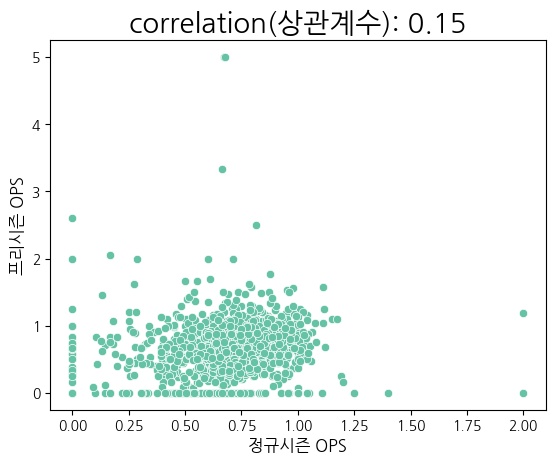

In [16]:
# 상관관계 알아보기

correlation = regular_season_intersection['OPS'].corr(preseason_intersection['OPS'])
sns.scatterplot(x=regular_season_intersection['OPS'], y=preseason_intersection['OPS'])
plt.title('correlation(상관계수): '+ str(np.round(correlation, 2)), fontsize=20)
plt.xlabel('정규시즌 OPS', fontsize=12)
plt.ylabel('프리시즌 OPS', fontsize=12)

'''
scatter가 선형적인 모습을 보이지 않는 것으로 보아 상관관계는 거의 없다고 본다.
''';
